In [1]:
import torch
import random
from collections import Counter
from itertools import combinations

from base_funcs_V2_1_1 import *
from model_V2 import *

from matplotlib import pyplot as plt

import numpy as np

In [2]:
def simEpisode_notrain(Init_states, Models, temperature, verbose=0):
    if Init_states is None:

        Init_states = init_game_3card() # [Lstate, Dstate, Ustate]

    public_cards = state2str(Init_states[-1].numpy().sum(axis=0))

    Log = f'Landlord Cards: {public_cards}\n'
    Qs = []

    unavail = ''
    history = torch.zeros((15,4,15))
    lastmove = ['',(0,0)]

    Turn = 0
    Npass = 0 # number of pass applying to rules
    Cpass = 0 # continuous pass
    Condition = 0

    Forcemove = True # whether pass is not allowed

    while True: # game loop
        # get player
        #print(Turn, lastmove)
        player = Init_states[Turn%3] 
        upper_state = Init_states[:-1][(Turn-1)%3].sum(dim=0)
        lower_state = Init_states[:-1][(Turn+1)%3].sum(dim=0)
        visible = Init_states[-1]
        # get card count
        card_count = [int(p.sum()) for p in Init_states]
        #print(card_count)
        CC = torch.zeros((4,15))
        CC[0][:min(card_count[0],15)] = 1
        CC[1][:min(card_count[1],15)] = 1
        CC[2][:min(card_count[2],15)] = 1
        #print(CC)

        # get action
        Bigstate = torch.cat([player.unsqueeze(0),
                                  str2state(unavail).unsqueeze(0),
                                  CC.unsqueeze(0),
                                  visible.unsqueeze(0), # new feature
                                  torch.zeros_like(visible).unsqueeze(0) + Turn%3, # role feature
                                  history])

        # generate inputs
        hinput = Bigstate.unsqueeze(0)
        #print(hinput.shape)

        model_inter = Models[0](hinput)
        slout = np.round(model_inter.flatten().detach().numpy(),0)
        P0 = np.append(slout[:15][None,:],upper_state.numpy()[None,:],axis=0).astype(np.int32)
        P1 = np.append(slout[15:][None,:],lower_state.numpy()[None,:],axis=0).astype(np.int32)
        print(f'{Turn} {Label[Turn%3]}: {Label[(Turn-1)%3]} ---{np.sum(np.abs(P0[0]-P0[1]))}\n',P0)
        print(f'{Turn} {Label[Turn%3]}: {Label[(Turn+1)%3]} ---{np.sum(np.abs(P1[0]-P1[1]))}\n',P1)
        #print('UT',upper_state.numpy())
        #print('LT',lower_state.numpy())
        role = torch.zeros((model_inter.shape[0],15)) + Turn%3
        
        #print(model_inter.shape, role.shape)
        # get all actions
        acts = avail_actions(lastmove[0],lastmove[1],Bigstate[0],Forcemove)

        # generate inputs 2
        model_inter = torch.concat([hinput[:,0].sum(dim=-2),hinput[:,5].sum(dim=-2),model_inter,role],dim=-1)
        #print(model_inter.shape)
        
        model_input2 = torch.stack([torch.cat((model_inter.flatten(),str2state(a[0]).sum(dim=0))) for a in acts])
        #print(model_input2.shape)
        # get q values
        output = Models[-1](model_input2).flatten()

        #print(output.shape)

        #print(output)
        if temperature == 0:
            Q = torch.max(output)
            best_act = acts[torch.argmax(output)]
        else:
            # get action using probabilistic approach and temperature
            probabilities = torch.softmax(output / temperature, dim=0)
            distribution = torch.distributions.Categorical(probabilities)
            
            q = distribution.sample()
            best_act = acts[q]
            Q = output[q]
        
        action = best_act

        
        Qs.append(Q.item())
        if Forcemove:
            Forcemove = False

        # conduct a move
        myst = state2str(player.sum(dim=0).numpy())
        cA = Counter(myst)
        cB = Counter(action[0])
        newst = ''.join(list((cA - cB).elements()))
        newunavail = unavail + action[0]
        newhist = torch.roll(history,1,dims=0)
        newhist[0] = str2state(action[0]) # first row is newest, others are moved downward
        
        #newlast = ['',(0,0)]
        play = action[0]
        if action[1][0] == 0:
            play = 'pass'
            Cpass += 1
            if Npass < 1:
                Npass += 1
            else:
                #print('Clear Action')
                newlast = ['',(0,0)]
                Npass = 0
                Forcemove = True
        else:
            newlast = action
            Npass = 0
            Cpass = 0

        #myst, action[0], newst, newunavail, newhist[0], newlast
        Log += f"{Label[Turn % 3]} {str(Turn).zfill(2)}    {myst.zfill(20).replace('0', ' ')} {play.zfill(20).replace('0', ' ')} by {Label[Turn % 3]}    {str(round(Q.item()*100,1)).zfill(5)}%\n"
        if Cpass == 2:
            Log += '\n'
        if verbose:
            print(Label[Turn%3], str(Turn).zfill(2), '   ', myst.zfill(20).replace('0',' '), play.zfill(20).replace('0',' '), 'by', Label[Turn%3], f'{round(Q.item()*100,1)}%')
            if Cpass == 2:
                print('')
        # record
        nextstate = str2state(newst)


        # update
        Init_states[Turn%3] = nextstate
        unavail = newunavail
        history = newhist
        lastmove = newlast
        
        if len(newst) == 0:
            Condition = 1
            break

        Turn += 1

    #if Condition == 1:
    if Turn %3 == 0:
        Log += f'\nLandlord Wins'
    else:
        Log += f'\nFarmers Win'
    if verbose:
        if Turn %3 == 0:
            print(f'\nLandlord Wins')
        else:
            print(f'\nFarmers Win')
    #print(len(BufferStatesActs[0]),len(BufferRewards[0]))
    #quit()
    return Turn, Qs, Log

In [3]:
if torch.get_num_threads() > 1:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)
#np.set_printoptions(precision=1, suppress=True, linewidth=150, formatter={'all': lambda x: f"{x:6.1f}"})

In [4]:
Label = ['Landlord','Farmer-0','Farmer-1'] # players 0, 1, and 2

v_M = 'H15-V2_1.2-Contester_0022600000'
N_history = int(v_M[1:3])

SLM = Network_Pcard_V1_1(N_history+5,5)#,Network_Pcard(N_history+4),Network_Pcard(N_history+4)
QV = Network_Qv_Universal_V1_1(6,15,512)

SLM.load_state_dict(torch.load(f'models/SLM_{v_M}.pt'))
QV.load_state_dict(torch.load(f'models/QV_{v_M}.pt'))

SLM.eval()
QV.eval()
print('Init Wt',SLM.fc1.weight.data)

Init Wt tensor([[-0.0670, -0.0324,  0.1160,  ..., -0.0002,  0.0325, -0.0043],
        [ 0.0157, -0.0401,  0.0251,  ...,  0.0291,  0.0340,  0.0134],
        [-0.0425,  0.0186, -0.0045,  ..., -0.0056, -0.0103,  0.0198],
        ...,
        [-0.0702,  0.0128, -0.0100,  ..., -0.0223,  0.0244, -0.0259],
        [ 0.0845,  0.0297,  0.0591,  ...,  0.0161, -0.0194, -0.0289],
        [ 0.0532,  0.0833,  0.0467,  ...,  0.0232,  0.0040, -0.0023]])


In [5]:
Deck = init_game_3card()

0 Landlord: Farmer-1 ---5
 [[1 2 2 1 1 1 1 1 2 1 2 0 1 0 0]
 [1 2 3 1 1 2 0 1 2 0 2 0 2 0 0]]
0 Landlord: Farmer-0 ---4
 [[2 1 2 2 0 1 1 2 1 1 1 1 2 0 0]
 [2 1 1 2 0 1 2 2 1 2 1 1 1 0 0]]
1 Farmer-0: Landlord ---8
 [[1 2 1 0 1 0 0 0 1 0 0 2 2 1 1]
 [1 1 0 0 2 0 1 0 0 1 0 3 1 1 1]]
1 Farmer-0: Farmer-1 ---7
 [[1 1 2 1 2 2 1 1 2 1 2 1 1 0 0]
 [1 2 3 1 1 2 0 1 2 0 2 0 2 0 0]]
2 Farmer-1: Farmer-0 ---2
 [[2 1 1 2 1 1 2 1 1 2 1 1 1 0 0]
 [2 1 1 2 0 1 2 2 1 2 1 1 1 0 0]]
2 Farmer-1: Landlord ---3
 [[1 2 0 0 1 0 1 0 0 1 0 3 1 1 0]
 [1 1 0 0 2 0 1 0 0 1 0 3 1 1 1]]
3 Landlord: Farmer-1 ---6
 [[1 2 2 1 0 1 1 2 2 1 2 0 2 0 0]
 [1 2 3 1 1 2 0 1 2 0 2 0 2 0 0]]
3 Landlord: Farmer-0 ---6
 [[2 1 2 2 1 2 1 1 1 1 1 1 1 0 0]
 [2 1 1 2 0 1 2 2 1 2 1 1 1 0 0]]
4 Farmer-0: Landlord ---6
 [[1 2 1 0 1 0 0 0 0 0 0 2 2 1 1]
 [1 1 0 0 2 0 0 0 0 1 0 3 1 1 1]]
4 Farmer-0: Farmer-1 ---6
 [[1 1 2 1 2 2 0 1 2 1 2 1 1 0 0]
 [1 2 3 1 1 2 0 1 2 0 2 0 2 0 0]]
5 Farmer-1: Farmer-0 ---4
 [[2 0 1 2 1 1 2 2 1 3 1 0 1 0 1]


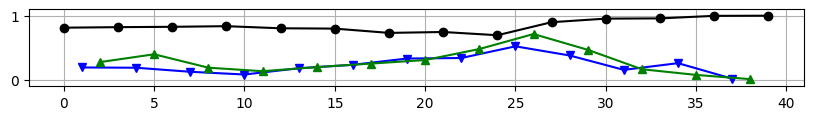

Player Turn |          Current Card |             Action                Win Rate
Landlord Cards: 47A
Landlord 00    346777899XJQQKAAA2BR             6789XJQK by Landlord    081.3%
Farmer-0 01       334566899XXJQQKA2                 pass by Farmer-0    019.3%
Farmer-1 02       3445556788XJJKK22                 pass by Farmer-1    027.7%

Landlord 03            34779QAAA2BR                    9 by Landlord    082.1%
Farmer-0 04       334566899XXJQQKA2                    A by Farmer-0    018.9%
Farmer-1 05       3445556788XJJKK22                 pass by Farmer-1    039.9%
Landlord 06             3477QAAA2BR                    2 by Landlord    082.7%
Farmer-0 07        334566899XXJQQK2                 pass by Farmer-0    012.6%
Farmer-1 08       3445556788XJJKK22                 pass by Farmer-1    019.0%

Landlord 09              3477QAAABR                   77 by Landlord    083.7%
Farmer-0 10        334566899XXJQQK2                   99 by Farmer-0    008.3%
Farmer-1 11       3445556788

In [17]:
Turn = 20
#while Turn < 50:
Turn, Qs, Log = simEpisode_notrain(
#[str2state('33455788XJJJQKAAA22R'),str2state('3445567799XXJQA22'),str2state('3466678899XQQKKKB')], #v1_029
None,
#[i.clone().detach() for i in Deck],
[SLM,QV],0.0,0)
#break
plt.figure(figsize=(10,1))
plt.plot(range(0,len(Qs),3),Qs[::3],marker='o',color='black')
plt.plot(range(1,len(Qs),3),Qs[1::3],marker='v',color='blue')
plt.plot(range(2,len(Qs),3),Qs[2::3],marker='^',color='green')
plt.ylim(-0.1,1.1)
plt.grid()
plt.show()

print('Player Turn |          Current Card |             Action                Win Rate')
print(Log)